In [47]:
# Step 1.0 - Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [48]:
import warnings
warnings.filterwarnings("ignore")

- Loading the dataset

In [49]:
data = pd.read_csv("RTA Dataset.csv")
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


- Viewing the columns contained in my dataset

In [ ]:
print("\nCOLUMN NAMES:")
data.columns


COLUMN NAMES:


Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

- Shaping my datset in column row format

In [8]:
data.shape

(12316, 32)

- Checking for mising values

In [11]:
data.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

- Dealing with missing values

In [ ]:
# drop columns with >50% missing
th = 0.5
cols_keep = data.columns[data.isnull().mean() < th]
data = data[cols_keep]

# fill categorical misses with "Unknown"
for c in data.select_dtypes(include='object').columns:
    data[c] = data[c].fillna("Unknown")

# if Time exists, extract hour
if "Time" in data.columns:
    try:
        data["Hour"] = pd.to_datetime(data["Time"], errors='coerce').dt.hour
        data["Hour"].fillna(data["Hour"].median(), inplace=True)
    except:
        pass

- Dropping the unecesary cloumns

- Many casuality fields apply only when injuries occur thus they cause noise and having too many missing values which we don't want to use in this process

- Showing statistics of our dataset

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Hour
count,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,...,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316.000000
unique,1074,7,5,3,7,4,8,18,5,6,...,4,3,6,4,7,6,9,20,3,NaN
top,15:30:00,Friday,18-30,Male,Junior high school,Employee,5-10yr,Automobile,Owner,Unknown,...,Driver or rider,Male,na,3,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury,NaN
freq,120,2041,4271,11437,7619,9627,3363,3205,10459,6811,...,4944,5253,4443,7076,5903,9608,11390,2263,10415,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.835823
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.202923
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000


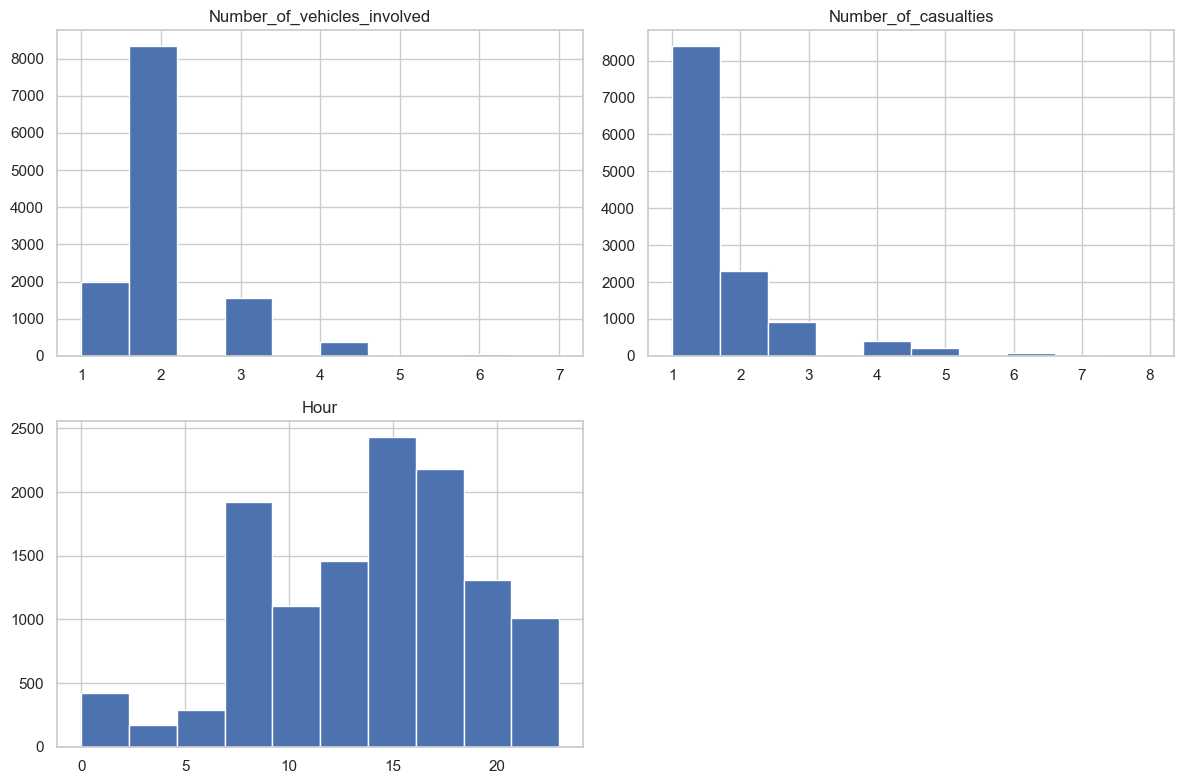

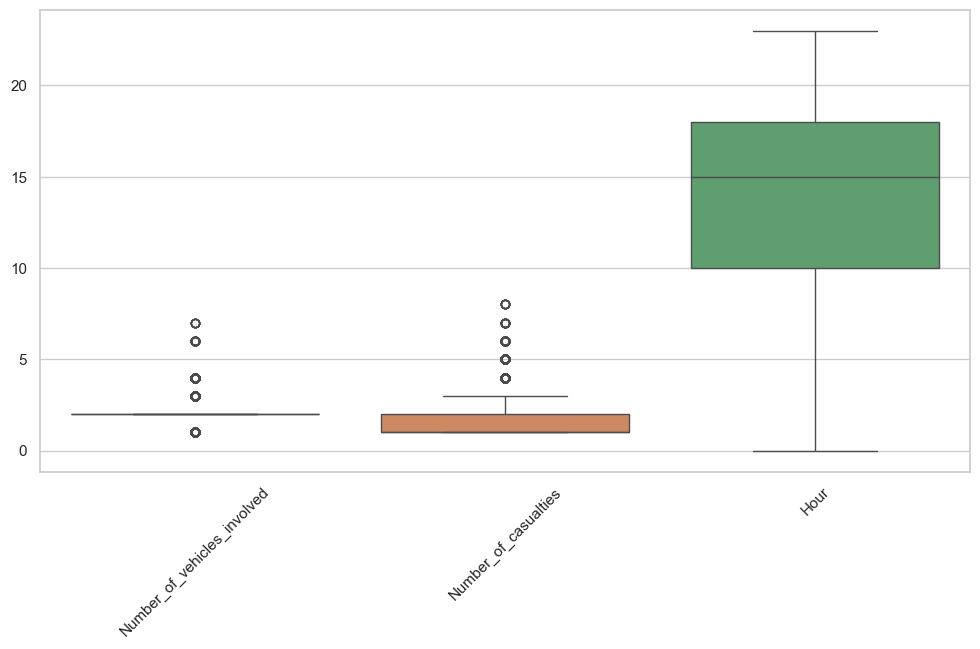


Value counts for: Time
Time
15:30:00    120
17:10:00    110
18:30:00    103
11:30:00     99
17:00:00     98
16:00:00     97
18:00:00     95
19:00:00     94
17:50:00     88
17:25:00     87
Name: count, dtype: int64

Value counts for: Day_of_week
Day_of_week
Friday       2041
Thursday     1851
Wednesday    1840
Tuesday      1770
Monday       1681
Saturday     1666
Sunday       1467
Name: count, dtype: int64

Value counts for: Age_band_of_driver
Age_band_of_driver
18-30       4271
31-50       4087
Over 51     1585
Unknown     1548
Under 18     825
Name: count, dtype: int64

Value counts for: Sex_of_driver
Sex_of_driver
Male       11437
Female       701
Unknown      178
Name: count, dtype: int64

Value counts for: Educational_level
Educational_level
Junior high school    7619
Elementary school     2163
High school           1110
Unknown                841
Above high school      362
Writing & reading      176
Illiterate              45
Name: count, dtype: int64

Value counts for: Vehicle_d

In [51]:
# basic describe
display(data.describe(include='all'))

# numeric histograms
nums = data.select_dtypes(include='number').columns.tolist()
if len(nums) > 0:
    data[nums].hist(figsize=(12,8))
    plt.tight_layout()
    plt.show()

# boxplots to check for outliers 
if len(nums) > 0:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[nums].fillna(0))
    plt.xticks(rotation=45)
    plt.show()

# frequency for main categorical variables
cats = data.select_dtypes(include='object').columns.tolist()
for c in cats[:6]:
    print("\nValue counts for:", c)
    print(data[c].value_counts().head(10))

- Handling outliers.

In [ ]:
numeric_cols = data.select_dtypes(include='number').columns.tolist()

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # capping the values
    data[col] = np.where(data[col] < lower, lower,
                       np.where(data[col] > upper, upper, data[col]))

print("Outlier capping completed.")


Outlier capping completed.


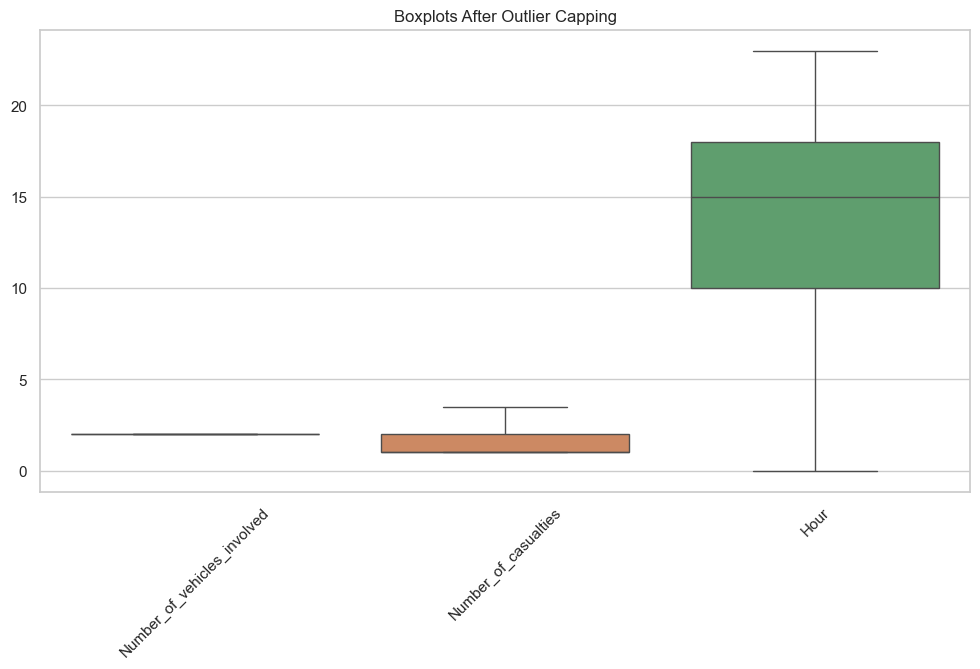

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplots After Outlier Capping")
plt.show()


- Correlation heatmap for numerical features

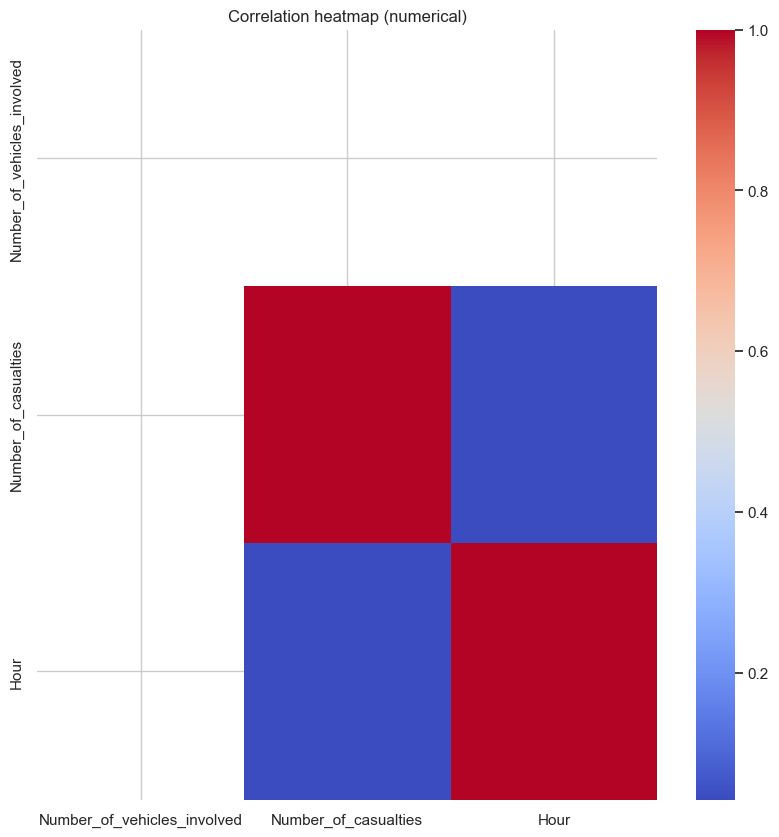

In [56]:
if len(nums) > 1:
    plt.figure(figsize=(10,10))
    sns.heatmap(data[nums].corr(), cmap='coolwarm')
    plt.title("Correlation heatmap (numerical)")
    plt.show()

- Selecting the appriopriate features

In [57]:
# ensure target name; change if different
target_col = "Accident_severity"
if target_col not in data.columns:
    raise ValueError(f"{target_col} not found in dataframe columns")

# encode target
le = LabelEncoder()
data[target_col] = le.fit_transform(data[target_col])

# one-hot encode (drop first to limit dims)
X = pd.get_dummies(data.drop(columns=[target_col]), drop_first=True)
y = data[target_col].copy()

X.shape, y.shape

((12316, 1259), (12316,))

- Feature scaling

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
# Mutual information for feature ranking
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "mi": mi}).sort_values("mi", ascending=False)
mi_df.head(20)

,feature,mi
7,Time_0:08:00,0.009637
505,Time_18:27:00,0.009469
639,Time_20:20:00,0.009254
444,Time_17:24:00,0.008617
547,Time_19:10:00,0.008268
50,Time_10:12:00,0.007724
148,Time_12:07:00,0.007594
273,Time_14:21:00,0.007497
847,Time_4:28:00,0.007357
780,Time_23:49:00,0.007267


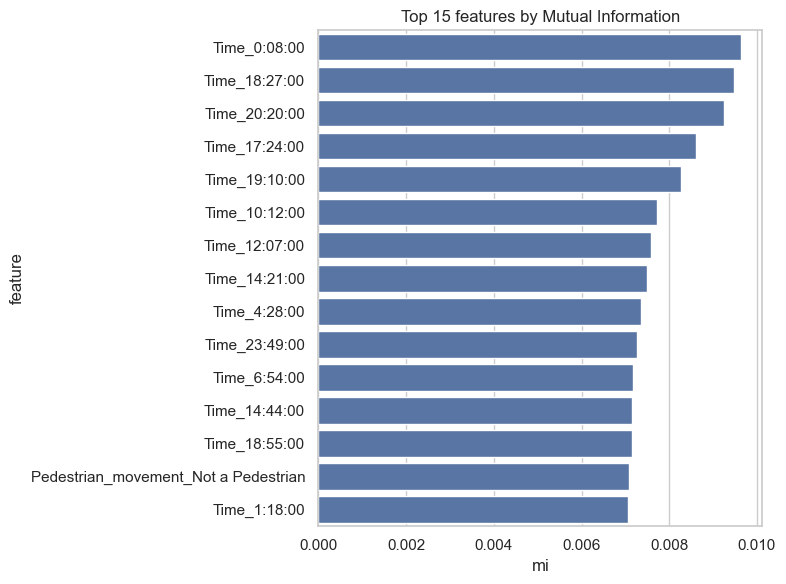

In [62]:
#  plot for top MI features
top_n = 15
plt.figure(figsize=(8,6))
sns.barplot(x='mi', y='feature', data=mi_df.head(top_n))
plt.title(f"Top {top_n} features by Mutual Information")
plt.tight_layout()
plt.show()


- Splitting the dataset into training and testing data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((9852, 1259), (2464, 1259))

- Appyling an FFNN

In [64]:
def make_model(input_dim):
    m = Sequential()
    m.add(Dense(128, activation='relu', input_shape=(input_dim,)))
    m.add(Dropout(0.3))
    m.add(Dense(64, activation='relu'))
    m.add(Dropout(0.2))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(len(np.unique(y)), activation='softmax'))
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

model = make_model(X_train.shape[1])
hist = model.fit(X_train, y_train, epochs=18, batch_size=32, validation_split=0.15, verbose=1)

Epoch 1/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8368 - loss: 0.5138 - val_accuracy: 0.8390 - val_loss: 0.4637
Epoch 2/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8524 - loss: 0.4030 - val_accuracy: 0.8342 - val_loss: 0.4641
Epoch 3/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8620 - loss: 0.3498 - val_accuracy: 0.8261 - val_loss: 0.4781
Epoch 4/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8734 - loss: 0.3196 - val_accuracy: 0.8227 - val_loss: 0.4934
Epoch 5/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8772 - loss: 0.2946 - val_accuracy: 0.8254 - val_loss: 0.5074
Epoch 6/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8866 - loss: 0.2689 - val_accuracy: 0.8153 - val_loss: 0.5479
Epoch 7/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8974 - loss: 0.2401 - val_accuracy: 0.8241 - val_loss: 0.5756
Epoch 8/18
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9071 - loss: 0.2192 - val_accuracy: 0

- Model Evaluation

In [65]:
pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall (weighted):", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted', zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.8299512987012987
Precision (weighted): 0.801921648740862
Recall (weighted): 0.8299512987012987
F1 (weighted): 0.8116135699269734

Classification report:
               precision    recall  f1-score   support

           0       0.32      0.29      0.31        31
           1       0.42      0.24      0.31       349
           2       0.87      0.94      0.90      2084

    accuracy                           0.83      2464
   macro avg       0.54      0.49      0.50      2464
weighted avg       0.80      0.83      0.81      2464



- Confusion matrix and a report

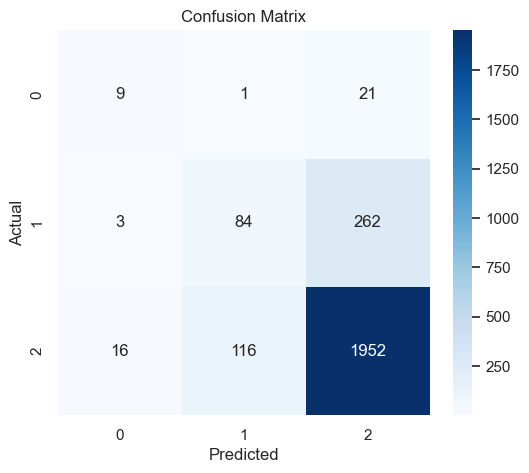

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- Training curve plots for the model

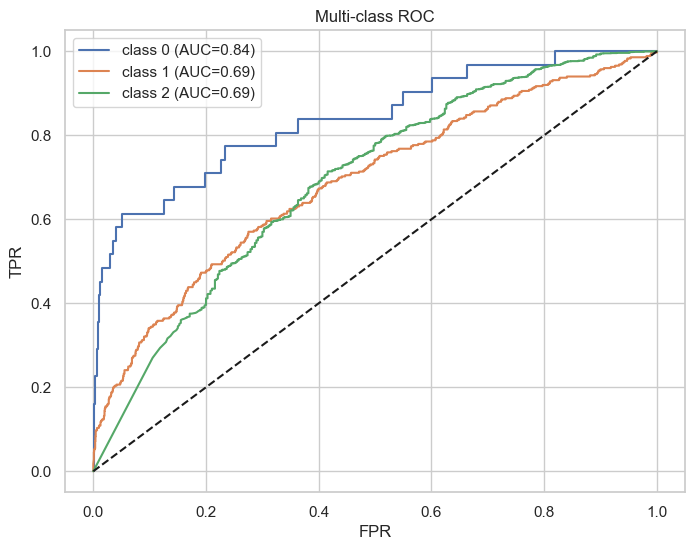

In [67]:
y_test_bin = label_binarize(y_test, classes=np.unique(y))
# pred_probs already computed
plt.figure(figsize=(8,6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"class {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Multi-class ROC")
plt.legend()
plt.show()

- Cross- Validating the model using k-fold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = []
fold = 1
for tr_idx, te_idx in kf.split(X_scaled):
    xtr, xte = X_scaled[tr_idx], X_scaled[te_idx]
    ytr, yte = y.values[tr_idx], y.values[te_idx]
    m = make_model(X_scaled.shape[1])
    m.fit(xtr, ytr, epochs=10, batch_size=32, verbose=0)
    loss, acc = m.evaluate(xte, yte, verbose=0)
    print(f"Fold {fold} acc: {acc:.4f}")
    cv_acc.append(acc)
    fold += 1

print("CV mean acc:", np.mean(cv_acc))

- Saving the model

In [ ]:
model.save("model1.h5")